In [3]:
from googleapiclient.discovery import build
import pandas as pd
import time
from googleapiclient import discovery
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
import numpy as np
from sklearn.utils import class_weight
import os
import random

In [4]:
#Makes results consistent

os.environ['PYTHONHASHSEED'] = '42'

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [5]:
df = pd.read_csv("Offensive_Comments_Data.csv")
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


# Pre-Processing

In [6]:
df.columns

Index(['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither',
       'class', 'tweet'],
      dtype='object')

The data seems to have unecessary columns in "Unnamed: 0" and "count".

Along with this the 'class' column reflects the class label (hate_speech, offensive_language, neither) that has the majority vote. With this in mind I believe that keeping those label columns would result in redundant information and unecessary noise, so it is best to drop those columns as well.

In [7]:
df = df.drop(["Unnamed: 0", "count", "hate_speech", "offensive_language", "neither"], axis=1)
df.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


"class" labels:


*   0 - Hate Speech
*   1 - Offensive Language
*   2 - Neither



In [8]:
df.shape

(24783, 2)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   24783 non-null  int64 
 1   tweet   24783 non-null  object
dtypes: int64(1), object(1)
memory usage: 387.4+ KB


In [10]:
df.isnull().sum()

,0
class,0
tweet,0


In [11]:
df.duplicated().sum()

np.int64(0)

In [12]:
df['class'].value_counts()

,count
class,
1,19190
2,4163
0,1430


<Axes: xlabel='class', ylabel='count'>

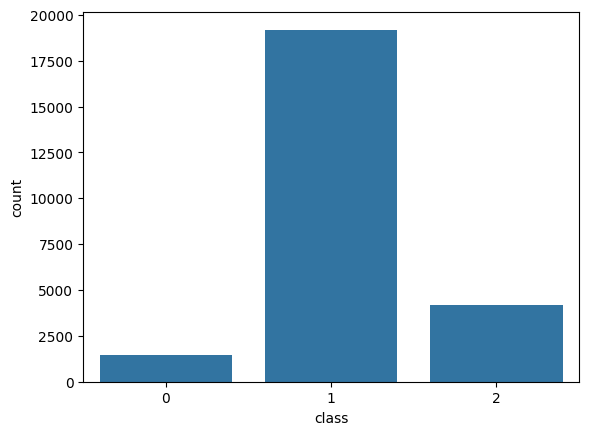

In [13]:
sns.countplot(x='class', data=df)

There seems to be a great imbalance among the distribution of classes


In [14]:
X = df['tweet']
y = df['class']

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp)


In [15]:
rus = RandomUnderSampler(random_state=0)

X_train_bal, y_train_bal = rus.fit_resample(X_train.to_frame(), y_train.to_frame())

In [16]:
y_train_bal.value_counts()

,count
class,
0,858
1,858
2,858


In [17]:
nlp = spacy.load("en_core_web_sm")

In [18]:
def preprocess_text(text):
    # Remove @mentions
    text = re.sub(r"@\S+", "", text)

    # Remove URLs
    text = re.sub(r"http\S+|www\S+", "", text)

    doc = nlp(text)

    # Lowercase, remove punctuation, remove stopwords, and lemmatization.
    tokens = [token.lemma_.lower() for token in doc if not token.is_punct and not token.is_stop]

    return " ".join(tokens)

In [19]:
X_processed = X_train_bal['tweet'].apply(preprocess_text)

In [20]:
X_train_bal.head()

,tweet
4046,@MattHomeTeam - you know what you did you fagg...
22108,This nigga jerry room smell like bad pussy!&#1...
12641,Look at this coon ass nigga here..... Standing...
23358,You know what fuck you too bitch your such a l...
17134,RT @RosieZaya1: Ur fucking white trash


In [21]:
X_processed.head()

,tweet
4046,know faggot literally thousand people radar ...
22108,nigga jerry room smell like bad pussy!&#128530
12641,look coon ass nigga stand damn toilet look man...
23358,know fuck bitch little hoe gt;.&lt
17134,rt ur fucking white trash


In [22]:
#Transforming our features into a matrix using TfidVectorizer for our model
vectorizer = TfidfVectorizer()
X_vectorized = vectorizer.fit_transform(X_processed)

# Neural Network Model

In [23]:
print(X_vectorized.shape)

(2574, 5276)


In [24]:
input_size = X_vectorized.shape[1]

In [25]:
print(y_train_bal.shape)

(2574, 1)


In [26]:
model = tf.keras.Sequential()
#Our vector has 5248 features so thats how many the initial layer should accept
model.add(tf.keras.layers.Dense(256, activation='relu', input_shape=(input_size,)))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(3, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [27]:
# Convert to int32 type
y_train_bal = y_train_bal.astype("int32")
y_val = y_val.values.astype("int32")


In [28]:
X_val_processed = X_val.apply(preprocess_text)
X_val_vectorized = vectorizer.transform(X_val_processed)
X_val_vectorized = X_val_vectorized.astype("float32").toarray()

In [29]:
cw = class_weight.compute_class_weight(class_weight='balanced',
                                       classes=np.unique(y_train_bal['class']),
                                       y=y_train_bal['class'])

In [30]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Fit the model
history = model.fit(X_vectorized, y_train_bal,
                    validation_data=(X_val_vectorized, y_val),
                    epochs=10,
                    batch_size=32,
                    class_weight=dict(enumerate(cw)))

Epoch 1/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.4782 - loss: 1.0015 - val_accuracy: 0.7281 - val_loss: 0.6612
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.8724 - loss: 0.3355 - val_accuracy: 0.6573 - val_loss: 0.9817
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9695 - loss: 0.0943 - val_accuracy: 0.8182 - val_loss: 0.6060
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9800 - loss: 0.0552 - val_accuracy: 0.7654 - val_loss: 0.8513
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9926 - loss: 0.0246 - val_accuracy: 0.7349 - val_loss: 1.1279
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9960 - loss: 0.0142 - val_accuracy: 0.7716 - val_loss: 1.0167
Epoch 7/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.9960 - loss: 0.0127 - val_accuracy: 0.7718 - val_loss: 1.0647
Epoch 8/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9965 - loss: 0.0108 - val_accuracy: 0.7958 - v

In [31]:
from sklearn.metrics import classification_report

# Predict on the test set
# Preprocess and vectorize the X_test data
X_test_processed = X_test.apply(preprocess_text)
X_test_vectorized = vectorizer.transform(X_test_processed)
X_test_vectorized = X_test_vectorized.astype("float32").toarray()


In [32]:
y_pred_test = model.predict(X_test_vectorized)
y_pred_test_labels = y_pred_test.argmax(axis=1)


print(classification_report(y_test, y_pred_test_labels))

test_loss, test_acc = model.evaluate(X_test_vectorized, y_test)
print("Test Accuracy:", test_acc)


155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
              precision    recall  f1-score   support

           0       0.21      0.52      0.30       286
           1       0.92      0.79      0.85      3838
           2       0.66      0.77      0.71       833

    accuracy                           0.77      4957
   macro avg       0.60      0.69      0.62      4957
weighted avg       0.84      0.77      0.80      4957

155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7739 - loss: 1.1680
Test Accuracy: 0.7704256772994995


Lets see how our neural network compares to a simpler model like logistic regression.

In [35]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(class_weight='balanced', max_iter=1000)
clf.fit(X_vectorized, y_train_bal)

# Evaluate
y_pred = clf.predict(X_test_vectorized)
print(classification_report(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.26      0.70      0.37       286
           1       0.97      0.80      0.88      3838
           2       0.75      0.92      0.82       833

    accuracy                           0.81      4957
   macro avg       0.66      0.80      0.69      4957
weighted avg       0.89      0.81      0.84      4957



Seems our neural network needs some more work to be done as it does a little worse compared to a simpler model like logistic regression.

Let's start by retrieving real-world data from youtube comments.

In [ ]:
def get_video_ids(api_key, channel_id, max_results=50):
    youtube = build('youtube', 'v3', developerKey=api_key)
    video_ids = []
    next_page_token = None

    while len(video_ids) < max_results:
        request = youtube.search().list(
            part='id',
            channelId=channel_id,
            maxResults=min(50, max_results - len(video_ids)),
            order='date',
            pageToken=next_page_token
        )
        response = request.execute()

        for item in response['items']:
            if item['id']['kind'] == 'youtube#video':
                video_ids.append(item['id']['videoId'])

        next_page_token = response.get('nextPageToken')
        if not next_page_token:
            break
        time.sleep(1)  # To respect API rate limits

    return video_ids



In [ ]:
def get_comments(api_key, video_id, max_comments=100):
    youtube = build('youtube', 'v3', developerKey=api_key)
    comments = []
    next_page_token = None

    while len(comments) < max_comments:
        request = youtube.commentThreads().list(
            part='snippet',
            videoId=video_id,
            maxResults=min(100, max_comments - len(comments)),
            pageToken=next_page_token,
            textFormat='plainText'
        )
        response = request.execute()

        for item in response['items']:
            comment = item['snippet']['topLevelComment']['snippet']
            comments.append({
                'video_id': video_id,
                'author': comment['authorDisplayName'],
                'text': comment['textDisplay'],
                'like_count': comment['likeCount'],
                'published_at': comment['publishedAt']
            })

        next_page_token = response.get('nextPageToken')
        if not next_page_token:
            break
        time.sleep(1)  # To respect API rate limits

    return comments


In [ ]:
def compile_comments(api_key, channel_id, num_videos=10, comments_per_video=100):
    video_ids = get_video_ids(api_key, channel_id, max_results=num_videos)
    all_comments = []

    for video_id in video_ids:
        comments = get_comments(api_key, video_id, max_comments=comments_per_video)
        all_comments.extend(comments)

    df = pd.DataFrame(all_comments)
    return df

In [ ]:
api_key = ''
channel_id = 'UCupvZG-5ko_eiXAupbDfxWw'  # CNN's channel ID

df_comments = compile_comments(api_key, channel_id, num_videos=10, comments_per_video=100)
df_comments.head()

,video_id,author,text,like_count,published_at
0,GJeFoEw9x0M,@madden6993,Well well well,0,2025-06-04T14:01:11Z
1,GJeFoEw9x0M,@wvo72,"Honestly, a dominant USA AI would be more tr...",0,2025-06-04T14:01:09Z
2,GJeFoEw9x0M,@chrispowers5568,This guy talking about genius concepts yet can...,0,2025-06-04T14:01:04Z
3,GJeFoEw9x0M,@gathrightcrystal,It's documented Biden 💻,0,2025-06-04T14:00:44Z
4,GJeFoEw9x0M,@Ali-s9r3z,Trump focuses on his reputation and interests ...,0,2025-06-04T14:00:33Z


In [ ]:
from google.colab import files
#To prevent constant api calls for the dataframe I decided to download it to my computer.
df_comments.to_csv("cnn_youtube_comments.csv", index=False)
files.download("cnn_youtube_comments.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [36]:
df_cnn_comments = pd.read_csv("cnn_youtube_comments.csv")
df_cnn_comments.head()

,video_id,author,text,like_count,published_at
0,GJeFoEw9x0M,@madden6993,Well well well,0,2025-06-04T14:01:11Z
1,GJeFoEw9x0M,@wvo72,"Honestly, a dominant USA AI would be more tr...",0,2025-06-04T14:01:09Z
2,GJeFoEw9x0M,@chrispowers5568,This guy talking about genius concepts yet can...,0,2025-06-04T14:01:04Z
3,GJeFoEw9x0M,@gathrightcrystal,It's documented Biden 💻,0,2025-06-04T14:00:44Z
4,GJeFoEw9x0M,@Ali-s9r3z,Trump focuses on his reputation and interests ...,0,2025-06-04T14:00:33Z


In [37]:
X_youtube_comments = vectorizer.transform(df_cnn_comments['text'])

In [38]:
pred_probs = model.predict(X_youtube_comments)
pred_classes = np.argmax(pred_probs, axis=1)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [39]:
df_cnn_comments['predicted_toxicity_label'] = pred_classes

In [41]:
df_cnn_comments.head(10)

,video_id,author,text,like_count,published_at,predicted_toxicity_label
0,GJeFoEw9x0M,@madden6993,Well well well,0,2025-06-04T14:01:11Z,2
1,GJeFoEw9x0M,@wvo72,"Honestly, a dominant USA AI would be more tr...",0,2025-06-04T14:01:09Z,1
2,GJeFoEw9x0M,@chrispowers5568,This guy talking about genius concepts yet can...,0,2025-06-04T14:01:04Z,1
3,GJeFoEw9x0M,@gathrightcrystal,It's documented Biden 💻,0,2025-06-04T14:00:44Z,2
4,GJeFoEw9x0M,@Ali-s9r3z,Trump focuses on his reputation and interests ...,0,2025-06-04T14:00:33Z,2
5,GJeFoEw9x0M,@gathrightcrystal,Blaming a computer for a computer 🤡,0,2025-06-04T14:00:09Z,2
6,GJeFoEw9x0M,@misterfunnybones,"I'm a cybernetic organism, living tissue over ...",0,2025-06-04T14:00:08Z,2
7,GJeFoEw9x0M,@gathrightcrystal,That's not ai we have the 🧾 ask the state depa...,0,2025-06-04T13:59:14Z,2
8,GJeFoEw9x0M,@chrispowers5568,By fictitious he means affairs employees absol...,0,2025-06-04T13:58:50Z,1
9,GJeFoEw9x0M,@gathrightcrystal,Great movie Hunter 💻🎥,0,2025-06-04T13:58:04Z,2
